# CROSS SECTIONAL ANALYSIS

In this notebook we will try to build a classifier which can answer our first research question: 

### Question: Will an issued fine be paid shortly after?

In [1]:
# Load the "autoreload" extension
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import pandas as pd
import matplotlib
import datetime
%matplotlib inline
#%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

# add the 'src' directory as one where we can import modules
src_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'src'))
sys.path.append(src_dir)

# self written packages
from data import data_utils
from data.preprocessing import preprocess

from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

### Read files from directory of processed data tables

In [2]:
dfs = data_utils.read_csv_from_dir(dir_name="processed")

-----------
## Preprocessing

### Get all CaseIDs from create_fine events:

In [3]:
create_fine_activities_RAW = deepcopy(dfs[2])
create_fine_uid = set(create_fine_activities_RAW["T:concept:name"])
len(create_fine_uid)

150370

### Get all CaseIDs from payment events:

In [4]:
payment_activities_RAW = deepcopy(dfs[6])
payment_uid = set(payment_activities_RAW["T:concept:name"])

### Create union of both sets to get all cases which are common

In [5]:
# union of both events
create_to_payment_uid = payment_uid & create_fine_uid
len(create_to_payment_uid)

69715

### Delete all CaseIDs which are part of any other set

In [6]:
result_ids = create_to_payment_uid
for i in range(0,len(dfs)):
    if i not in [2,6]:
        helper = deepcopy(dfs[i])
        helper = set(helper["T:concept:name"])
        result_ids = result_ids - helper

### Amount of unique cases which only exist of create_fine and payment event

In [7]:
len(result_ids)

46383

### Add Column to create_fine data frame wich holds the dependent variable (label)

In [8]:
data = create_fine_activities_RAW.set_index("T:concept:name")
data["label"] = 0
payment_indices = list(result_ids)
data.loc[payment_indices, "label"] = 1

In [9]:
data.head()

,index,E:amount,E:article,E:concept:name,E:dismissal,E:lifecycle:transition,E:org:resource,E:points,E:time:timestamp,E:vehicleClass,label
T:concept:name,,,,,,,,,,,
A1,0,35.0,157.0,Create Fine,NIL,complete,561.0,0.0,7/24/06 12:00 AM,A,0
A100,2,35.0,157.0,Create Fine,NIL,complete,561.0,0.0,8/2/06 12:00 AM,A,0
A10000,7,36.0,157.0,Create Fine,NIL,complete,561.0,0.0,3/9/07 12:00 AM,A,0
A10001,12,36.0,157.0,Create Fine,NIL,complete,537.0,0.0,3/19/07 12:00 AM,A,0
A10004,18,36.0,157.0,Create Fine,NIL,complete,537.0,0.0,3/20/07 12:00 AM,A,0


### Label distribution

In [10]:
summary = data.groupby(["label"]).count().loc[:,['E:amount']]
summary = summary.rename(columns={'E:amount': 'count'})
summary

,count
label,
0,103987
1,46383


------
## Feature Engineering

E:org:resource Distribution is an categorical feature, but due to the high variation we will keep it as numerical one

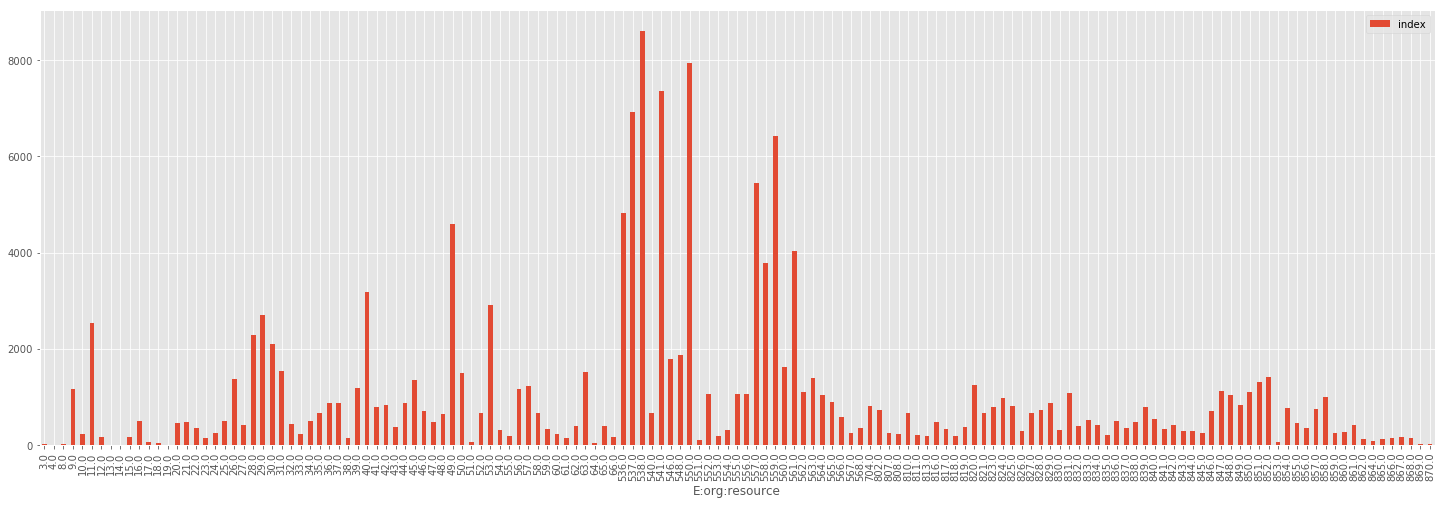

In [11]:
fig, ax = plt.subplots(figsize=(25,8))
data.groupby('E:org:resource').count().T.head(1).T.rename({"index":"count"}).plot(kind="bar", ax=ax);

## Definition of the E:dismissal variable:
Dismissal contains a character that encodes the diverse reasons for a possible dismissal of the fine. A value of NIL encodes that the fine is not dismissed (i.e. has to be paid) any other value encodes different motivations.

### Redesign feature E:dismissal so that 1 encodes "mandatory payment" & 0 encodes the "payment is dropped"

In [12]:
data["dismissal"] = 0
dismissal_nil_indices = list(data[data["E:dismissal"]=='NIL'].index)
data.loc[dismissal_nil_indices, "dismissal"] = 1
data = data.drop('E:dismissal', axis=1)
data.reset_index(inplace=True)

# drop unnecessary columns
not_used_columns = ['index','T:concept:name','E:concept:name', 'E:lifecycle:transition']
data = data.drop(not_used_columns, axis=1)

In [13]:
data.head()

,E:amount,E:article,E:org:resource,E:points,E:time:timestamp,E:vehicleClass,label,dismissal
0,35.0,157.0,561.0,0.0,7/24/06 12:00 AM,A,0,1
1,35.0,157.0,561.0,0.0,8/2/06 12:00 AM,A,0,1
2,36.0,157.0,561.0,0.0,3/9/07 12:00 AM,A,0,1
3,36.0,157.0,537.0,0.0,3/19/07 12:00 AM,A,0,1
4,36.0,157.0,537.0,0.0,3/20/07 12:00 AM,A,0,1


In [14]:
summary = data.groupby(["label","dismissal"]).count().loc[:,["E:amount"]]
summary = summary.rename(columns={'E:amount': 'count'})
summary

count
label dismissal        
0     0             504
      1          103483
1     1           46383

### Create dummy feature out of E:vehicleClass
Because most vehicle classes are A we create one feature called car which is 1 if it is in class A and 0 else

count
label E:vehicleClass        
0     A               100957
      C                 1999
      M                 1027
      R                    4
1     A                45755
      C                  457
      M                  171

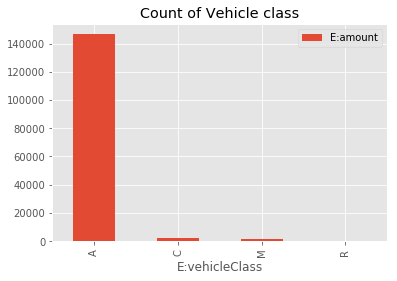

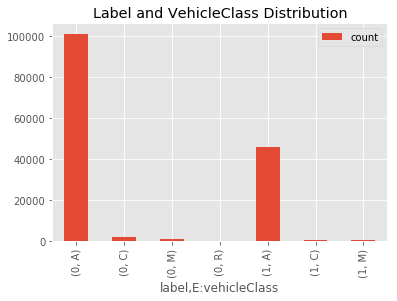

In [15]:
summary = data.groupby(["label","E:vehicleClass"]).count().loc[:,['E:amount']]
summary = summary.rename(columns={'E:amount': 'count'})
display(summary)
data.groupby(["E:vehicleClass"]).count().loc[:,['E:amount']].plot(kind="bar",title="Count of Vehicle class");
summary.plot(kind="bar",title="Label and VehicleClass Distribution");

In [16]:
data["car"] = [1 if "A" in vehicle_class else 0 for vehicle_class in data["E:vehicleClass"]]

In [17]:
data.head(5)

,E:amount,E:article,E:org:resource,E:points,E:time:timestamp,E:vehicleClass,label,dismissal,car
0,35.0,157.0,561.0,0.0,7/24/06 12:00 AM,A,0,1,1
1,35.0,157.0,561.0,0.0,8/2/06 12:00 AM,A,0,1,1
2,36.0,157.0,561.0,0.0,3/9/07 12:00 AM,A,0,1,1
3,36.0,157.0,537.0,0.0,3/19/07 12:00 AM,A,0,1,1
4,36.0,157.0,537.0,0.0,3/20/07 12:00 AM,A,0,1,1


### Drop unused columns


In [18]:
cleaned_features = data.drop("E:vehicleClass",axis=1)

### Create season features

To account for the seasonality of the data we will create simple features for Spring=2, Summer=3, Autumn=4 and Winter=1.

In [19]:
cleaned_features.head()

,E:amount,E:article,E:org:resource,E:points,E:time:timestamp,label,dismissal,car
0,35.0,157.0,561.0,0.0,7/24/06 12:00 AM,0,1,1
1,35.0,157.0,561.0,0.0,8/2/06 12:00 AM,0,1,1
2,36.0,157.0,561.0,0.0,3/9/07 12:00 AM,0,1,1
3,36.0,157.0,537.0,0.0,3/19/07 12:00 AM,0,1,1
4,36.0,157.0,537.0,0.0,3/20/07 12:00 AM,0,1,1


count
season label       
autumn 0      17339
       1       8160
spring 0      22333
       1       9668
summer 0      50223
       1      21979
winter 0      14092
       1       6576

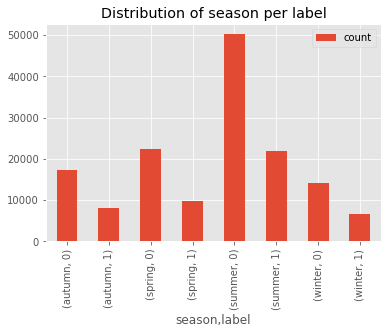

In [20]:
cleaned_features['E:time:timestamp'] = pd.to_datetime(cleaned_features['E:time:timestamp'],format='%m/%d/%y %H:%M %p')
cleaned_features["season"]=cleaned_features["E:time:timestamp"].apply(lambda dt: (dt.month%12 + 3)//3)
# Rename values
cleaned_features.loc[cleaned_features[cleaned_features["season"]==1].index, "season"] = "winter"
cleaned_features.loc[cleaned_features[cleaned_features["season"]==2].index, "season"] = "spring"
cleaned_features.loc[cleaned_features[cleaned_features["season"]==3].index, "season"] = "summer"
cleaned_features.loc[cleaned_features[cleaned_features["season"]==4].index, "season"] = "autumn"

summary = cleaned_features.groupby(["season","label"]).count().loc[:,["E:time:timestamp"]]
summary = summary.rename(columns={"E:time:timestamp":"count"})
display(summary)
summary.plot(kind="bar",title="Distribution of season per label");

In [21]:
dummy_features = pd.get_dummies(cleaned_features["season"])
# Reappend to features
cleaned_features = pd.concat([cleaned_features, dummy_features], axis=1).drop(["season"],axis=1)
cleaned_features.head(2)

,E:amount,E:article,E:org:resource,E:points,E:time:timestamp,label,dismissal,car,autumn,spring,summer,winter
0,35.0,157.0,561.0,0.0,2006-07-24 12:00:00,0,1,1,0,0,1,0
1,35.0,157.0,561.0,0.0,2006-08-02 12:00:00,0,1,1,0,0,1,0


### Create monthly features


months april       august       december       february       january        \
label      0     1      0     1        0     1        0     1       0     1   
count   6608  2831  18797  7817     4806  2137     5213  2206    4073  2233   

months   july         june       march         may       november        \
label       0     1      0     1     0     1     0     1        0     1   
count   19062  8165  12364  5997  6370  2842  9355  3995     4721  2476   

months october       september        
label        0     1         0     1  
count     5455  2665      7163  3019

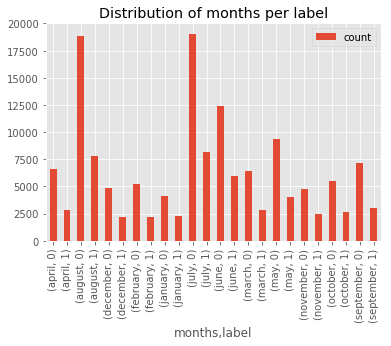

In [22]:
cleaned_features["months"] = cleaned_features["E:time:timestamp"].apply(lambda dt: dt.strftime('%B').lower())
#display(cleaned_features.head(2))
summary = cleaned_features.groupby(["months","label"]).count().loc[:,["E:time:timestamp"]]
summary = summary.rename(columns={"E:time:timestamp":"count"})

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(summary.T)
summary.plot(kind="bar",title="Distribution of months per label");

In [23]:
dummy_features = pd.get_dummies(cleaned_features["months"])
# Reappend to features
cleaned_features = pd.concat([cleaned_features, dummy_features], axis=1).drop(["months"],axis=1)
cleaned_features.head(2)

,E:amount,E:article,E:org:resource,E:points,E:time:timestamp,label,dismissal,car,autumn,spring,...,december,february,january,july,june,march,may,november,october,september
0,35.0,157.0,561.0,0.0,2006-07-24 12:00:00,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1,35.0,157.0,561.0,0.0,2006-08-02 12:00:00,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


-------
## Prepare dataframe for classification

In [24]:
from sklearn.preprocessing import scale
from copy import deepcopy
# target variable
target_column = data["label"] 
# Drop timestamp and label
cleaned_features = cleaned_features.drop(["E:time:timestamp","label"],axis=1)
# scale all non dummy features
numerical_cols = ["E:amount", "E:article","E:org:resource", "E:points"]
cleaned_features.loc[:,numerical_cols]=pd.DataFrame(scale(cleaned_features.loc[:,numerical_cols]), columns=numerical_cols)
                                

In [25]:
# drop some not useful features
monthly_features = ["april","august", "december", "february",
                    "january", "july", "june", "march", "may",
                    "november", "october", "september"]
seasonal_features = ["autumn", "spring", "summer","winter"]

features = cleaned_features.drop(seasonal_features +["dismissal","E:org:resource"],axis=1)
print("Final Features:\n")
display(features.head())

Final Features:



,E:amount,E:article,E:points,car,april,august,december,february,january,july,june,march,may,november,october,september
0,-0.196602,0.641364,-0.136543,1,0,0,0,0,0,1,0,0,0,0,0,0
1,-0.196602,0.641364,-0.136543,1,0,1,0,0,0,0,0,0,0,0,0,0
2,-0.176366,0.641364,-0.136543,1,0,0,0,0,0,0,0,1,0,0,0,0
3,-0.176366,0.641364,-0.136543,1,0,0,0,0,0,0,0,1,0,0,0,0
4,-0.176366,0.641364,-0.136543,1,0,0,0,0,0,0,0,1,0,0,0,0


--------------
## Model Selection

### Create Train/Test Split

In [26]:
seed_num = 5
X_train, X_test, y_train, y_test = train_test_split(features, target_column, test_size=0.10, stratify=target_column, random_state=seed_num)

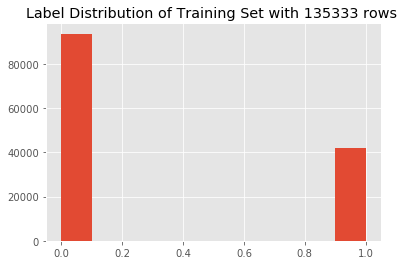

In [27]:
fig, ax = plt.subplots()
ax.set_title("Label Distribution of Training Set with {} rows ".format(y_train.shape[0]))
ax.hist(y_train);

### Define parameters for GridSearch Random Forest

In [28]:
#parameters = {'n_estimators':np.arange(5,30,step=5), 'criterion':('gini', 'entropy')}
parameters = {'n_estimators':[5,10,15], 'criterion':['gini', 'entropy'],'max_features': ['auto','sqrt','log2']}


### Perform Gridsearch with cross validation for Random Forest

In [29]:
# create random forest classifier and perform grid search with cross validation
rf = RandomForestClassifier(random_state=seed_num, n_jobs=-1, class_weight="balanced")
clf = GridSearchCV(rf, parameters, cv=10, scoring='roc_auc')
clf.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=5,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [5, 10, 15], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

### Get best parameter combination

In [30]:
bp = clf.best_params_
bp

{'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 15}

### Apply parameters to Random forest

In [31]:
rf_with_best_params = RandomForestClassifier(n_estimators=bp['n_estimators'], criterion=bp['criterion'],random_state=seed_num)

### Rerun model with parameters

In [32]:
# fit model onto train set
#rf_with_best_params.fit(X_train,y_train)
# predict labels
rf_with_best_params_pred = clf.predict(X_test)
# predict probabilities
rf_with_best_params_probs = clf.predict_proba(X_test)

### Readjust probability to predict 0 - Want to be more cautious for non payment

In [57]:
threshold_probability = 0.485
rf_with_best_params_pred = [0 if prob[0] > threshold_probability else 1 for prob in rf_with_best_params_probs]

### Distribution of prediction and ground truth

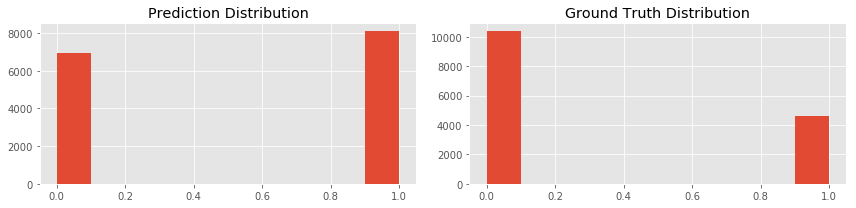

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
axes[0].set_title("Prediction Distribution")
axes[0].hist(rf_with_best_params_pred)

axes[1].set_title("Ground Truth Distribution")
axes[1].hist(y_test)
fig.tight_layout();

### Accuracy Score

In [59]:
accuracy_score(y_test, rf_with_best_params_pred)

0.58775021613353728

In [60]:
fpr, tpr, thresholds = roc_curve(y_test, rf_with_best_params_pred)
roc_auc = auc(fpr, tpr)

In [61]:
roc_auc

0.62036013596524131

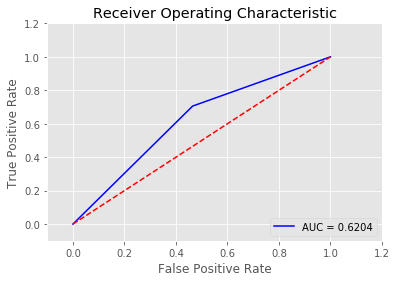

In [62]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()